# Homework 5 Coding: Transport Modeling

For this coding assignment, you will write functions to calculate molar flux (and sometimes current density) for several given applications.  I will do much of the coding for you, at first, but then let you handle more and more of it, as we move along.

## Part I: Gas-phase diffusion in a PEMFC cathode.

For this scenario, we will model gas-phase transport in the gas diffusion layer (GDL) of a PEMFC cathode.

The cathode is 100 microns thick, with a porosity (gas-phase volume fraction) of 57%, with the tortuosity factor modeled using a Bruggeman coefficient of $n = -0.5$.

Use the Cozeny-Karman relationship to estimate the cathode GDL permeability, with a carbon particle diameter of 0.5 microns, and an average pore radius of 2 microns.

We will simulate transport at 60 C, where the dynamic viscosity of moist air is $\mu = 2.08\times 10^{-5}\,\frac{\rm kg}{\rm m-s}$.  The conditions at the two nodes are:

1. Node 1: in the gas flow channel
- Pressure = 1 atmosphere
- $X_{\rm O_2} = 0.21$
- $X_{\rm N_2} = 0.79$
- $X_{\rm H_2O} = 0.0$

2. Node 2: in the catalyst layer, where O$_2$ is consumed and H$_2$O is produced:
- Pressure = 100 kPa
- $X_{\rm O_2} = 0.16$
- $X_{\rm N_2} = 0.80$
- $X_{\rm H_2O} = 0.04$

The gas-phase species diffusion coefficients are:
- O$_2$: $2.438\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- N$_2$: $2.798\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- H$_2$O: $1.9\times 10^{-5}\,\frac{\rm m^2}{\rm s}$

In [63]:
import numpy as np

dY = 100e-6 # m
eps_g = 0.57
n_Brugg = -0.5

d_part = 0.5e-6
r_p = 2e-6

T = 333.15 # K
P_1 = 101325 # Pa
P_2 = 100000 # Pa

R = 8.3145 # J/mol-K
F = 96485  # C/mol equiv

# Species order: O2, N2, H2O_v
X_k_1 = np.array([0.21, 0.79, 0.0])
X_k_2 = np.array([0.16, 0.80, 0.04])

mu = 2.08e-5 #kg/m-s

D_k = np.array([2.438e-5, 2.798e-5, 1.9e-5]) #m2/s

### We are going to load all parameters into a series of Python dictionaries

We will pass these dictionaries to our function.  The dictionaries just make it more efficient then having 12 different input variables.

In [64]:
# State variables for node 1:
state1 = {'X_k':X_k_1, 'P':P_1, 'T':T}
# State variables for node 2:
state2 = {'X_k':X_k_2, 'P':P_2, 'T':T}

# Geometric and microstructure parameters:
geom = {'eps_g':eps_g, 'n_Brugg':n_Brugg, 'd_part':d_part, 'dY':dY}
# Gas properties
gas_props = {'D_k':D_k, 'mu':mu}

### Example for using values stored in dictionaries:

In [113]:
# To access a dictionary value:
print(gas_props['mu'])
print(state1['X_k'])
X_sum = sum(state1['X_k'])
print('The mole fractions sum to',X_sum)

2.08e-05
[0.21 0.79 0.  ]
The mole fractions sum to 1.0
34


## YOUR CODE GOES HERE:

Create a function that calculates the species fluxes, given our input dictionaries.

The function must return an array `N_k` that provides the species molar fluxes in mol/m$^2$-s.

Calculating tortuosity factor:
$\tau_\mathrm{fac,m}=\gamma_m\epsilon_m^n$ and we are assuming $\gamma$ is 1 and n is -0.5. This will be the same for all gas species because they will encounter the same microstructure.

Calculating Permeability ($m^2$):
$K_g=\frac{\phi^3_gd_p^2}{72\tau_\mathrm{frac,gas}(1-\phi^2)}$ $\tau_\mathrm{frac,gas}$ can be substituted for $\tau_\mathrm{gas}^2$. Or maybe not, when I do that my answers do not match up with yours, but when dont do the substitution my answers match up perfectly.


Calculating $V_\mathrm{conv}$:

$V_\mathrm{conv}$ is obtained using Darcy's law: $V_\mathrm{conv}=-\frac{K_g}{\mu}\nabla P$ Where our one dimensional modeling leads $\nabla P$ to be $\nabla P_y=\frac{P_2-P_1}{\mathrm{dY}}$.


Calculating $V_\mathrm{k,diff}$ (m/s):

$V_k=\frac{-D_\mathrm{eff}\nabla X_k}{X_k}$
- Where $D_\mathrm{eff}=\frac{\epsilon}{\tau_\mathrm{fac}}*D_k$
- and $\nabla X_k = \frac{X_{k,2}-X_{k,1}}{\mathrm{dY}}$
    - and X_k = $\frac{X_{k,2}-X_{k,1}}{2}$ (because our layers are the same size)
    
Finally calculating N_k:
$N_k = C_{int}*X_k*(V_\mathrm{conv}+V_\mathrm{k,diff})$
- Where $C_{int}$ is the concentration at the interface, and because our layers are the same size it is just an average of the concentrations of the two different states
    - Also, $C_k=\frac{n_k}{V}=\frac{P}{RT}$


In [68]:
def pemfc_gas_transport(state1, state2, geom, gas_props):
    N_k = np.zeros_like(state1['X_k'])
    
    #Calculating Vconv for all of the gasses:
    #calculating permeability of the imput gas
    t_fac = geom['eps_g']**geom['n_Brugg'] #no units
    K_g = (geom['eps_g']**3.*geom['d_part']**2.)/(72*t_fac*(1-geom['eps_g'])**2.) #m^2
    grad_P = (state2['P']-state1['P'])/geom['dY']
    V_conv = (-K_g/gas_props['mu'])*grad_P #Convective diffusivity (m/s)
    
    #Calculating V_k_diff
    D_eff = gas_props['D_k']*(geom['eps_g']/t_fac) #m^2/s
    X_k_int = (state1['X_k']+state2['X_k'])/2 #no units
    grad_X = (state2['X_k']-state1['X_k'])/geom['dY']
    V_k_diff = -D_eff*grad_X/X_k_int #m/s
    
    #Calculating N_k (mol/(m^2*s))
    V_k = V_conv+V_k_diff #m/s
    C_k_int = (((state1['X_k']*state1['P'])/(R*T))+((state2['X_k']*state2['P'])/(R*T)))/2 #(mol/m^3)
    C_int = (state1['P']+state2['P'])/(2*R*T)
    N_k = C_int*X_k_int*V_k
    print(N_k)
    return N_k
    
    

### Now calculate the fluxes between nodes 1 and 2 (you do not need to do anything; just run the cell)
### Then check your answers against mine:

[ 0.20188196  0.00456448 -0.1176394 ]


Text(0.5, 0, 'Species')

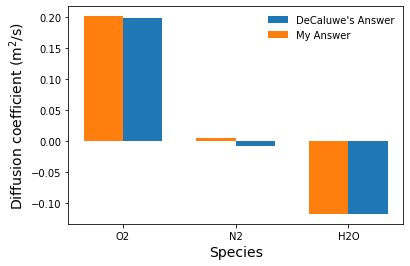

In [69]:
N_k_calc = pemfc_gas_transport(state1, state2, geom, gas_props)

from matplotlib import pyplot as plt
width = 0.35
N_k_check = np.array([0.19913, -0.007275, -0.11794]) #mol/m2/s

fig, ax = plt.subplots()

labels = ['O2', 'N2', 'H2O']
x = np.arange(len(labels))

ax.bar(x+width/2,N_k_check,width)
ax.bar(x-width/2,N_k_calc,width)
ax.legend(['DeCaluwe\'s Answer','My Answer'],frameon=False)

ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylabel('Diffusion coefficient (m$^2$/s)',fontsize=14)
ax.set_xlabel('Species',fontsize=14)

## Part II: Charged species transport in a liquid electrolyte:

Next we will calculate molar fluxes for a liquid electrolyte in a battery anode.  These calculations will be for electro-diffusion only - there is no convection!

The molar density of the electrolyte is assumed constant at 1100 moles per m$^3$

The temperature is 45$^\circ$C.

The electrolyte is LiPF$_6$, dissolved in a generic "solvent" molecule, with the following conditions:

1. Node 1:
- $X_{\rm Li^+} = 0.03$
- $X_{\rm PF^-_6} = 0.03$
- $X_{\rm Solvent} = 0.94$
- Electric potential $\phi_1 = 0.9$ V

2. Node 2:
- $X_{\rm Li^+} = 0.06$
- $X_{\rm PF^-_6} = 0.06$
- $X_{\rm Solvent} = 0.88$
- Electric potential $\phi_2 = 0.5$ V

The distance between the nodes is 30 microns, and the average diameter of the solid active material particles is 5 microns.  The anode porosity (electrolyte volume fraction) is 23%, and the tortuosity is characterized by a Bruggeman coefficient of -0.5.

In [92]:
C_elyte = 1100 #mol/m3

# Species order: Li+, PF6-, solvent
X_k_1 = np.array([0.03, 0.03, 0.94])
X_k_2 = np.array([0.06, 0.06, 0.88])

z_k = np.array([1., -1., 0.])

T = 318.  #K

dY = 30e-6

D_k = np.array([1.52e-10, 0.25e-10, 1e-12])

phi_1 = 0.9
phi_2 = 0.5

d_part = 5e-6

eps_elyte = 0.23
n_brugg = -0.5

## ENTER CODE HERE 

### to Create the Necessary Dictionaries. We will call the states just 's1' and 's2', this time:

In [93]:
s1 = {'x_k':X_k_1,'phi':phi_1,'T':T}
s2 = {'x_k':X_k_2,'phi':phi_2,'T':T}

geom = {'dY':dY,'d_part':d_part,'eps_elyte':eps_elyte,'n_brugg':n_brugg}
elyte_pars = {'c_elyte':C_elyte,'z_k':z_k,'D_k':D_k}

## NOW CREATE YOUR FLUX-CALCULATING FUNCTION:
The equation below solves for the migration flux for diffusion when electric field is applied to a dilute solution of charged particles using diffusion coefficients: 

<center>$N_k=-D_k\nabla C_k-D_kC_k\frac{z_kF}{RT}\nabla \phi$</center>
The second term can be simplified through the equation: $D_\mathrm{k,mig}=D_kC_k\frac{z_kF}{RT}$

Also, $\nabla C_k$ can be expanded to: $\frac{C_k}{X_k}\nabla X_k$

Currently known values are: $D_k$, $z_k$, F, R, and T.\
Thus, $C_k$, $\nabla X_k$, $\nabla \phi$, and $D_\mathrm{eff,k}$ must be solved for.
 - In this case C_k is C_k_int, and like part 1 it can be solved just as an average of the C_k values in state 1 and state 2.  To find C_k, all you have to do is multiply the mol fraction by the molar density.
 - The gradient of Xk is: $\frac{x_\mathrm{k,2}-x_\mathrm{k,1}}{dY}$
 - The gradient of $\phi$ is:$\frac{\phi_\mathrm{k,2}-\phi_\mathrm{k,1}}{dY}$ 
 - Since there are solid structures in the anode that take up space, the $D_k$ values must be converted to effective diffusion coefficients through the equation: $D_\mathrm{eff}=\epsilon^{1-a_m}*D_k$. Where $a_m$ is the Bruggman coefficient.
     - This equation is using the Bruggman correlation.  It allows the avoidance of calculating $\tau_\mathrm{fac}$ which was unavoidable in the last part due to the cocurrent convection flow.


In [94]:
def electrolyte_transport(state1, state2, geom, liq_pars):
    N_k = np.zeros_like(s1['x_k']) #initialize N_k so I dont get a weird error.
#Solving for unknowns
    #Solving for C_k:
    c_k_1 = s1['x_k']*elyte_pars['c_elyte']
    c_k_2 = s2['x_k']*elyte_pars['c_elyte']
    c_k_int = (c_k_2+c_k_1)/2 #(mol/m^3) for each species
    
    #Solving for grad_x_k:
    grad_x_k = (s2['x_k']-s1['x_k'])/geom['dY'] #(1/m)
    x_k_int = (s2['x_k']+s1['x_k'])/2 #X_k is also needed, no units. This is just an average of the X_k values in the different states
    
    #solving for grad_phi:
    grad_phi = (s2['phi']-s1['phi'])/geom['dY'] # (V/m)
    
    #Solving for D_eff_k:
    D_eff_k = geom['eps_elyte']**(1-geom['n_brugg'])*elyte_pars['D_k'] #(m^2/s)
    
#Grouping parameters together:
    grad_Ck = (c_k_int/x_k_int)*grad_x_k #(mol/m^4)
    D_k_mig = D_eff_k*c_k_int*((elyte_pars['z_k']*F)/(R*T)) #(m^2/s)
    
#Finally solving for the molar flux
    N_k = -D_eff_k*grad_Ck-D_k_mig*grad_phi #(mol/m^2*s)
    return N_k

Now we loop over a range of Node 2 electric potentials.  We use the fluxes to calculate the current density:
\begin{equation}
i = F\sum_k z_kN_k
\end{equation}

In [95]:
dPhi = np.linspace(0,1.1,25)
currents = np.zeros_like(dPhi)
N_k = np.zeros((len(dPhi), len(z_k)))


for j, phi in enumerate(dPhi):
    s2['phi'] = phi
    N_k[j,:] = electrolyte_transport(s1,s2, geom, elyte_pars)
    currents[j] = np.dot(z_k,N_k[j,:])*F


## Plot the currents and check them against mine.
(You do not need to enter anything)
### For what potential is the current equal to zero?

Zero current at dPhi =  0.8868918122866205


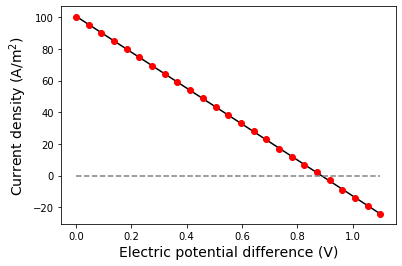

In [96]:
current_check = np.array([100.,  95.,  90.,  85.,  80.,  75.,  69.,
                          64.,  59.,  54.,  49.,  43.,  38.,  33.,
                          28.,  23.,  17.,  12.,   7.,   2.,  -3.,
                          -9.,    -14., -19., -24.])

plt.plot(dPhi, currents, 'k')
plt.plot(dPhi, current_check, 'ro', markerfacecolor=None)
plt.plot(dPhi, np.zeros_like(dPhi),'--',color='0.5')
plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Current density (A/m$^2$)',fontsize=14)

zero=np.interp(0, np.flip(currents), np.flip(dPhi))
print('Zero current at dPhi = ',zero)


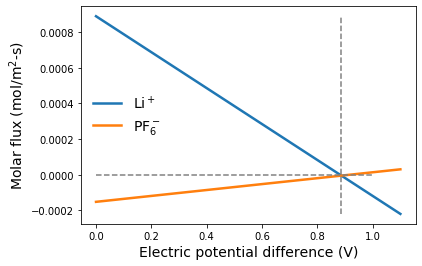

In [97]:

plt.plot(dPhi, N_k[:,0],linewidth=2.5)
plt.plot(dPhi, N_k[:,1],linewidth=2.5)

plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Molar flux (mol/m$^2$-s)',fontsize=14)
plt.legend(['Li$^+$','PF$_6^-$'],frameon=False,fontsize=14)
plt.plot([zero,zero],[N_k[-1,0],N_k[0,0]],'--',color='0.5')
plt.plot([0,1],[0,0],'--',color='0.5')

## Discuss the plots above in this Markdown block.  When is zero ionic current achieved?

Zero ionic current is achieved when the current density of the anode is 0. Due to charge neutrality if there is no net flux of ions, then there will be no net movement of electrons and no current will flow. This is roughly the potential of the Anode.  This makes sense because when the chemical potential is balenced by the electrical potential then there will be no net movement of species. In this case both charge carriers have 0 molar flux when there is 0 ionic current. Also there is no net diffusional flux from either species because both species have the same charge (in opposite directions) and they have the same concentration gradient between the two states.

I would have expected the zero current value to be exactly 0.9V, because we didnt account for any voltage losses due to ohmic, activation, or transport losses.


### Now predict current as a function of electrolyte volume fraction $\varepsilon_{\rm elyte}$

(You do not need to type anything)

Text(0, 0.5, 'Current Density (A/m$^2$)')

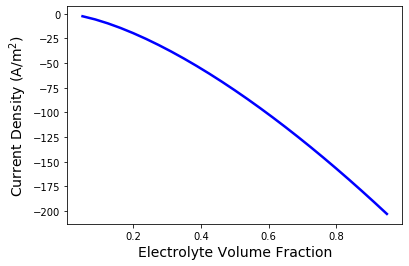

In [98]:
eps_array = np.linspace(0.05,0.95,25)

currents = np.zeros_like(eps_array)
for j, eps in enumerate(eps_array):
    geom['eps_elyte'] = eps
    N_k = electrolyte_transport(s1, s2, geom, elyte_pars)
    currents[j] = np.dot(elyte_pars['z_k'],N_k)*F
    
plt.plot(eps_array, currents,'b',linewidth=2.5)
plt.xlabel('Electrolyte Volume Fraction', fontsize=14)
plt.ylabel('Current Density (A/m$^2$)',fontsize=14)

### Discuss the results.  If you were designing a high-performance anode, what $\varepsilon_{\rm elyte}$ value would you pick?  Why?

From this graph maximizing the electrolyte volume fraction would maximize the current density that I am able to achieve. This graph is showing this because as our model goes, increasing the electrolyte area increaes the effective diffusvity of ions in the electrolyte leading to higher performance. Which is true, but our model does not account for the transport of species in the anode itself and for the reaction sites in the anode.

If the anode density is too low, then there will not be enough pathways to get electrons away from reaction sites to the external circut. I would want to pick an anode density that maximizes the diffusion of ionic and electronic species. Since electronic species move much easier than ions, likely there would need to be a higher amount of electrolyte to balence out the ion and electron fluxes. Also, the anode surface area corresponds to the potential reaction sites, so the more anode loading the faster the kinetics of the Anode will be. This pushes for there to be a lower electrolyte fraction. 

The numbers you use in these problems are normally used in most devices so, I would like to stay around 23%. A more mathmatic approach is that on this chart the steeper the slope the more "bang for buck" is gained because you gain more current density per volume fraction of electrolyte. The steepest part of the curve would have the most bang for buck, and that seems to be at around 40%, so I will go with that. One could find the negative maximum of the second derivitve of this curve if they wanted to be precise/fancy.

## Part III. Charged defects in a proton-conducting ceramic:

The protonic ceramic membrane in this section has a fixed crystal lattice that can be occupied by one of three species:

- An oxygen atom, O$^\times$ (this is considered the neutral species)
- A vacancy,V$_{\rm O}^{\bullet\bullet}$ which has a charge of +2, relative to the oxygen
- An oxygen atom with a proton attached, OH$^\bullet$

The lattice site concentration is assumed fixed at 22,325 mol per m$^3$.

The vacancy and proton are considered mobile, while the oxide is considered fixed.  We will simulate transport at 600$^\circ$C, where the diffusion coefficients are:

- $D_{\rm V_{\rm O}^{\bullet\bullet}} = 1.28\times 10^{-12}\,\frac{\rm m^2}{\rm s}$
- $D_{\rm O^\times} = 0.0\,\frac{\rm m^2}{\rm s}$
- $D_{\rm OH^\bullet} = 7.46\times 10^{-11}\,\frac{\rm m^2}{\rm s}$

The membrane also has a small amount of electronic conductivity, $\sigma_{\rm el} = 0.001\,\frac{\rm S}{\rm m}$.

We will simulate transport between two nodes, which are 20 microns apart.  The conditions are:

1. Node 1:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.336$
- $X_{\rm O^\times} = 0.627$
- $X_{\rm OH^\bullet} = 0.037$
- $\phi_1 = 1.1$

2. Node 2:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.018$
- $X_{\rm O^\times} = 0.938$
- $X_{\rm OH^\bullet} = 0.044$
- $\phi_2 = 0.0$

## Enter the data, here:

In [151]:
#Concenctrations
x_k_1 = np.array([0.336,0.627,0.037]) #mol fractions: V0,Ox,OH(proton)
x_k_2 = np.array([0.018,0.938,0.044]) #mol fractions: V0,Ox,OH(proton)

#Charges:
z_k = np.array([2,0,1]) #same order as above, V0,Ox,OH(proton)

#voltages
phi_1 = 1.1 #V
phi_2 = 0.0 #V

#Ceramic parameters:
lat_sites = 22325 #mol/m^3
e_cond = 0.001 # S/m
D_k = np.array([1.28*10**-12,0,7.46*10**-11]) #V0,Ox,OH(proton)

#Geometric parameters
dY = 20*10**-6 #m

#System status and re-initializing constants
T = 873 #K
R = 8.3145 # J/mol-K
F = 96485  # C/mol equiv

#Creating dictionaries
s1 = {'x_k':x_k_1, 'phi':phi_1, 'T':T} #State 1
s2 = {'x_k':x_k_2, 'phi':phi_2, 'T':T} #State 2
geom = {'dY':dY} #Geometric factors (may be pointless because there is only one value)
ceramic_pars = {'lat_sites':lat_sites,'e_cond':e_cond,'D_k':D_k,'z_k':z_k} #Ceramic parameters
#cons = {'F':F,'R':R} #fundamental constants

c_k_1 = s1['x_k']*ceramic_pars['lat_sites']
c_k_2 = s2['x_k']*ceramic_pars['lat_sites']
c_k_int = (c_k_2+c_k_1)/2 #(mol/m^3) for each species
    
#Solving for grad_x_k:
grad_x_k = (s2['x_k']-s1['x_k'])/geom['dY'] #(1/m)
x_k_int = (s2['x_k']+s1['x_k'])/2 #X_k is also needed, no units
grad_Ck = (c_k_int/x_k_int)*grad_x_k #(mol/m^4)
N_k = -ceramic_pars['D_k']*grad_Ck
print(N_k)

[ 0.00045436 -0.         -0.00058291]


## CREATE YOUR TRANSPORT FUNCTION HERE.
This function should return the fluxes, N_k, and the total current (ionic + electronic).

Calculating N_k:
N_k can be calculated the same way as before: 
<center>$N_k=-D_k\nabla C_k-D_kC_k\frac{z_kF}{RT}\nabla \phi$</center> 
The biggest difference is that $D_k=D_\mathrm{k,eff}$ because the electrolyte is a solid (vol frac = 1). The analogous to the ions in part two are the defects in the ceramic membrane and the analogous to the elyte concentration is the amount of oxygen sites in the electrolyte.

Calculating the total current:
<center>$i_\mathrm{tot} = i_\mathrm{ion}+i_e$</center>

Solving for $i_\mathrm{ion}$:
The contribution to the ionic current can be calculated through summming up the charges and the fluxes of every species in the electrolyte. However, the units on this calculation are: $\frac{\mathrm{molequiv}*\mathrm{molSpecies}}{m^2*s}$ multiplying by faradays constant will make this an equation for acurrent density. The full equation is listed below:

<center>$i_\mathrm{ion} = F\sum_{} z_k*N_k$</center>

Solving for $i_e$:\
Ohms law can be used to solve for electric current: $V=IR$, thus: $i_e=\frac{V}{R}$. V in this case will be the change in voltage between the two nodes.\
To solve for R: $R=\frac{\rho*L}{A}$. Where L in this case is dY, and $\rho$ is the reciprocal of conductivity. A is kind of arbitrary here so R will be solved as a resistance as a function of area: $\frac{\Omega}{m^2}$. This will also have i be a current density rather than a total current (which is preferable anyway and also matches $i_\mathrm{ion}$).\
The final equation for $i_e$ will be:
<center>$i_e = \frac{-(\phi_2-\phi_1)*\sigma}{dY}$</center>
There is a negative sign in front of the change in voltage because we are moving negative charge in the opposite direction of the postively charged ions.

In [160]:
def protonic_transport(state1, state2, geom, ceramic_pars):
    #initializing flux and current arrays:
    N_k = np.zeros_like(s1['x_k'])
    current = np.zeros_like(s1['x_k'])
    
#Calculating N_k:
    #Solving for unknowns
    #Solving for C_k:
    c_k_1 = s1['x_k']*ceramic_pars['lat_sites']
    c_k_2 = s2['x_k']*ceramic_pars['lat_sites']
    c_k_int = (c_k_2+c_k_1)/2 #(mol/m^3) for each species
    
    #Solving for grad_x_k:
    grad_x_k = (s2['x_k']-s1['x_k'])/geom['dY'] #(1/m)
    x_k_int = (s2['x_k']+s1['x_k'])/2 #X_k is also needed, no units
    
    #solving for grad_phi:
    grad_phi = (s2['phi']-s1['phi'])/geom['dY'] # (V/m)
    
    #Grouping parameters together:
    grad_Ck = (c_k_int/x_k_int)*grad_x_k #(mol/m^4)
    D_k_mig = ceramic_pars['D_k']*c_k_int*((ceramic_pars['z_k']*F)/(R*T)) #(m^2/s)
    
    #Finally solving for the molar flux
    N_k = -ceramic_pars['D_k']*grad_Ck-D_k_mig*grad_phi #(mol/m^2*s)
    
#Calculating Current
    #Calculating ionic current:
    i_ion = F*np.sum(ceramic_pars['z_k']*N_k)

    #calculating the electronic current:
    i_e = (-(s2['phi']-s1['phi'])*ceramic_pars['e_cond'])/geom['dY']
    
    #putting the two current values together:
    current = i_ion+i_e
    
    return N_k, current

## Here, we loop over a range of electric potential diffrerences between node 1 and node 2.

You do not need to do anything; just run the cell.

We will plot both the total current and the Faradaic efficiency, as a function of $\Delta \phi$.  

The Faradaic efficiency $\eta_{\rm Far}$ refers to the fact that the electronic leakage current is "undesired," for the protonic fuel cell.  We want all current to move ions across the membrane.  Therefore we find the efficiency as:
\begin{equation}
    \eta_{\rm Far} = \frac{i_{\rm ion}}{i_{\rm total}}
\end{equation}

(99, 100)

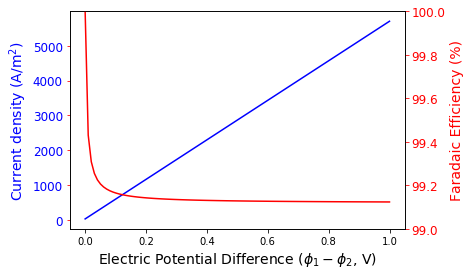

In [161]:
dPhi = np.linspace(0.0, 1.0, 100)
eta_Far = np.zeros_like(dPhi)
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    Nk, i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)
    i_ion = np.dot(Nk,ceramic_pars['z_k'])*F
    
    eta_Far[j] = 100*i_ion/i_tot[j]
    
    
# Plot the results:
fig, ax = plt.subplots()
plt.plot(dPhi, i_tot,color='b')

# Create a 2nd y axis:
ax2 = ax.twinx()
ax2.plot(dPhi, eta_Far,'r')

# Formatting:
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, V)', fontsize=14)

ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)
ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)

ax2.set_ylabel('Faradaic Efficiency (%)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.set_ylim((99,100))

## In this markdown cell, discuss the plot.  What explains the trends?

To check your answers, your total current should go from roughly zero at $\Delta\phi = 0$, to nearly 6000 A/m$^2$ at $\Delta\phi = 1.0.$ Over the same range, the Faradaic efficiency should go from 100% to roughly 99.1%.

As the electric potential difference across the electrolyte increases the current density increases linearly with it. This is because the potential difference is the driving force to push ions across the membrane. As the driving force increases the movement of ions and thus current density should increse with it.  This model does not include any of the forces behind where the potenital difference comes from (the difference in potential at the anode and cathode), it only sets the difference.  The way we wrote our equations, the current density will be linearly correlated with $\Delta\phi$.  We did not account for the resistivity of the ceramic electrolyte to the moving ions which would cause losses in voltage that would hamper performance more and more as our current density increaes.  Further we are assuming that we are able to transport gasses to the cell in a manner that can perfectly replenish all species no matter the current density (which in reality is not possible).

Faradaic efficiency starts off at 100% because at no voltage there is no electronic leakage current, but there is some ionic current.  This ionic current is due to the ions moving across the concentration gradient between both of the states.  There is no such driving force for the electrons in the electrolyte.  As a potential forms across the electrolyte, the ionic current increases to a non-zero value causing the faradaic efficiency to drop under 100%. Both the ionic and electronic currents vary linearly with the change in voltage.  Since the ionic conductivity is so much higher than the electric current, the increases in electric current to the total current are pretty much negligable.  So, the ratio of the electric current to the ionic current will remain relatively the same which is why it pretty much flattens out.  Though, the electric current is slowly gaining ground which is why the curve is lowering slightly.

This cell is only looking at the electrolyte, in reality there could be faradaic efficiency losses due to side reactions happening at the electrodes.

### Now loop over a smaller range of potentials, to see where we get a net current of zero.

(you do not need to type anything; just run the cell).

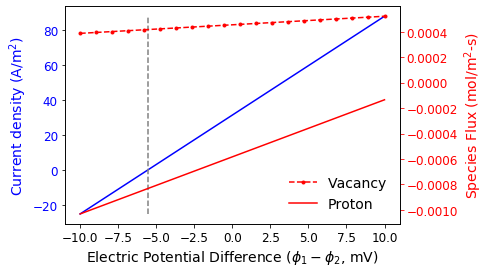

In [162]:
dPhi = np.linspace(-0.01, 0.01, 20)
N_k = np.zeros((len(dPhi),len(state1['X_k'])))
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    N_k[j,:], i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)

fig, ax = plt.subplots()
plt.plot(1000*dPhi, i_tot,color='b')

zero = 1000*np.interp(0,i_tot,dPhi)
plt.plot([zero,zero],[i_tot[0],i_tot[-1]],'--',color='0.5')

ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)

ax.tick_params(axis='x',color='k',labelcolor='k',labelsize=12)
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, mV)', fontsize=14)
#ax.set_xlim((-0.01,0.01))

ax2 = ax.twinx()
ax2.plot(1000*dPhi, N_k[:,0],'r.--')
ax2.plot(1000*dPhi, N_k[:,2],color='r')

ax2.set_ylabel('Species Flux (mol/m$^2$-s)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)

ax2.legend(['Vacancy','Proton'],fontsize=14,frameon=False)

### Discuss the result.  Is the 'zero current' condition the same as for the battery anode?  


The zero current condition is not the same as for the battery Anode.  For the battey Anode, 0 current density occurs when the molar flux of both species is 0. In this caset the 0 current condition is when the flux from the two charged species cancel each other out.  Initailly there are more protons on the side with state 2 so with no current density the protons want to flow backwards.  The opposite is true of the oxygen ion vacancies.

What about your model equations explains the trends?
All charged defect fluxes in the electrolyte increase linearly with the change in voltage. So the two charged defect  fluxes, the oxygen vacancies and protons, should increase linearly with the potential difference.  The reason the fluxes are not 0 at 0 potential difference is because there is still diffusion due the the concentration gradient in the defects between the two sides of the electrolyte. Causing a slight current density even when there is no voltage applied to the cell.

Further the slope of the proton contribution to current density is steeper the that of the oxygen ion vacancies.  The slope of the curve is a function of the concentration and the diffusivity of hte species.  The concentration of the oxygen ions is just under 10X higher than that of the protons, the diffusivity of the protons is over 10x higher than the diffusivity of the oxygen ions leading the protons having a larger effect on current density per increase in potential difference.